In [2]:
import pydicom
import matplotlib.pyplot as plt
import os
import numpy as np
file_dir = os.path.dirname(os.getcwd()) # the directory that options.py resides in

print(file_dir)
root_dir = file_dir.split("/code")[0]
dataset_dir = root_dir+"/dataset"
dataset_dir

/home/mengyi/code/ddib


'/home/mengyi/dataset'

In [3]:
def MaxMinNormalizer(data, maxFactor = 0):
    data_max = np.max(data)
    if data_max < maxFactor:
        data_max = maxFactor
    data_min = np.min(data)
    #print(data_max, data_min)
    data_normalize = (data - data_min) / (data_max - data_min)
    print(f"data max: {data_max}, data min: {data_min}")
    return data_normalize

def window_pixel_array(ds):
    pixel_array = ds.pixel_array
    if 'WindowWidth' in ds and 'WindowCenter' in ds:
        #print("defined")
        window_width = ds.WindowWidth
        window_center = ds.WindowCenter
        if isinstance(window_width, pydicom.valuerep.DSfloat):
            window_width = [window_width]
        if isinstance(window_center, pydicom.valuerep.DSfloat):
            window_center = [window_center]
    
        windowed_image = (pixel_array - (window_center[0] - window_width[0] / 2)) / window_width[0] * 255.0
        windowed_image = np.clip(windowed_image, 0, 255).astype(np.uint16)
    else:
        windowed_image = pixel_array
    
    return windowed_image

def loadPETValue(directory):
    data = []
    for file_name in sorted(os.listdir(directory)):
        full_file_name = os.path.join(directory, file_name)
        ds = pydicom.dcmread(full_file_name)
        pixel_array = ds.pixel_array
        image_index = ds.ImageIndex
        data.append((image_index, pixel_array))

    data_sorted = sorted(data, key=lambda x: x[0])
    sorted_values = np.array([pixel_array for _, pixel_array in data_sorted])
    return sorted_values

def calScaleFactor(data):
    non_zero_elements = data[data > 1]
    # print(data.mean(), non_zero_elements.mean())
    mean_non_zero = non_zero_elements.mean()
    return mean_non_zero


In [4]:
def viewData(data):
    
    flatten_data = data.flatten()
    flatten_data = flatten_data[flatten_data < 2000]
    counts, bins, patches = plt.hist(flatten_data, bins=10, edgecolor='black', alpha=0.7)

    percentages = 100 * counts / len(flatten_data)

    for i in range(len(patches)):
        plt.text(bins[i] + (bins[i+1] - bins[i])/2, counts[i], f'{percentages[i]:.2f}%', 
                ha='center', va='bottom')

    # plt.title('Histogram with Percentage')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    plt.show()

    threshold = np.percentile(flatten_data, 99.99)
    return threshold

def calSUV(ds):
    patient_weight = float(ds.PatientWeight) * 1000  # Convert to grams
    # print(ds.RadiopharmaceuticalInformationSequence)
    injected_dose = float(ds.RadiopharmaceuticalInformationSequence[0].RadionuclideTotalDose)  # Total injected dose
    half_life = float(ds.RadiopharmaceuticalInformationSequence[0].RadionuclideHalfLife)  # Half-life of the radionuclide

    # Time data extraction
    acquisition_time = ds.AcquisitionTime.split('.')[0]  # Scan time
    injection_time = ds.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartTime.split('.')[0]    
    
    # Convert times to seconds
    acquisition_time_seconds = int(acquisition_time[:2]) * 3600 + int(acquisition_time[2:4]) * 60 + int(acquisition_time[4:])
    injection_time_seconds = int(injection_time[:2]) * 3600 + int(injection_time[2:4]) * 60 + int(injection_time[4:])
    delta_t = acquisition_time_seconds - injection_time_seconds  # Delay between injection and sca

    # Get the pixel array and rescale
    pixel_array = ds.pixel_array
    rescale_slope = float(ds.RescaleSlope)
    rescale_intercept = float(ds.RescaleIntercept)
    activity_concentration = pixel_array * rescale_slope + rescale_intercept

    # Calculate the decay factor
    decay_factor = 2 ** (-delta_t / half_life)

    # Calculate SUV
    # print(f"delta_t: {delta_t}, max activity_concentration: {np.max(activity_concentration)}, patient_weight: {patient_weight}, injected_dose: {injected_dose}, decay_factor: {decay_factor}")
    suv = (activity_concentration * patient_weight) / (injected_dose * decay_factor)
    return suv

def normSUV(suv, threshold = 6):
    if threshold:
        suv = np.clip(suv, 0, threshold)
    return suv

def calSUVVolume(directory):
    data = []
    for file_name in sorted(os.listdir(directory)):
        full_file_name = os.path.join(directory, file_name)
        ds = pydicom.dcmread(full_file_name)
        suv = calSUV(ds)
        image_index = ds.ImageIndex
        data.append((image_index, suv))

    data_sorted = sorted(data, key=lambda x: x[0])
    sorted_suv_values = np.array([suv for _, suv in data_sorted])
    return sorted_suv_values

def suvToImage(suv):
    image = suv * 255.0 / 6.0
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.colorbar(label='SUV')
    plt.title('SUV Image')
    plt.axis('off')
    plt.show()


(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0012) Instance Creation Date              DA: '20220221'
(0008, 0013) Instance Creation Time              TM: '182827.310400'
(0008, 0016) SOP Class UID                       UI: Positron Emission Tomography Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.156.112605.159303470343965.220224102511.4.6352.66116
(0008, 0020) Study Date                          DA: '20211208'
(0008, 0021) Series Date                         DA: '20211208'
(0008, 0022) Acquisition Date                    DA: '20211208'
(0008, 0023) Content Date                        DA: '20220221'
(0008, 002a) Acquisition DateTime                DT: '20211208123040.7484'
(0008, 0030) Study Time                          TM: '122859'
(0008, 0031) Series Time                         TM: '123040.748400'
(0008, 0032) Acquisition Time                    TM: '12

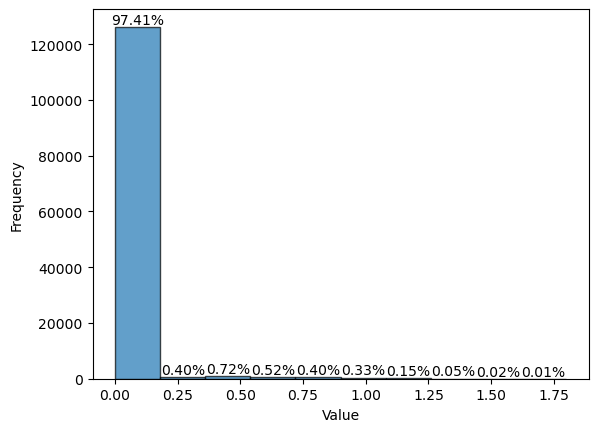

Mean SUV: 0.017320502357856142, Max SUV: 1.7984386115189261


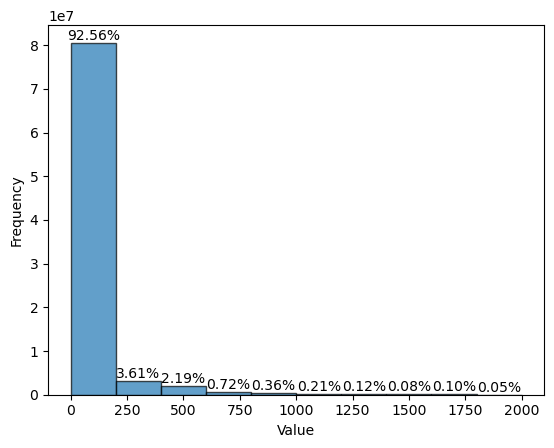

1935.0 15828
data max: 7.954209133301116, data min: 0.0
max in windowed: 0.07158200657063431


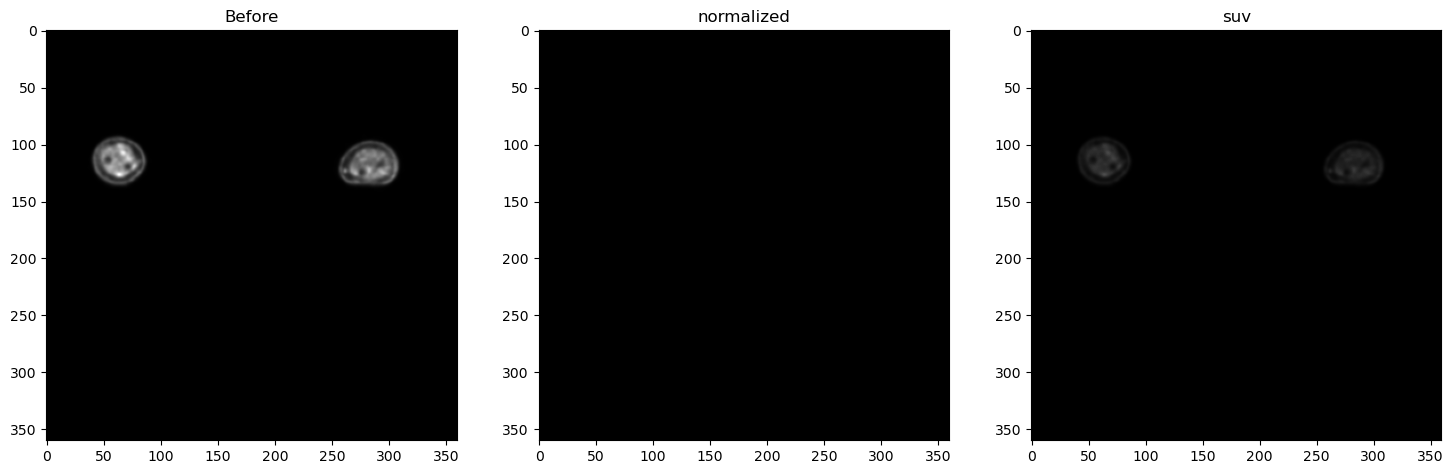

In [5]:
uExplorer_dir = "uExplorer/1st_uExplorer"
file_name = "Anonymous_ANO_20220224_1824561_122859/2.886 x 600 WB NORMAL/00000063.dcm"
full_file_name = os.path.join(dataset_dir, uExplorer_dir, file_name)
ds = pydicom.dcmread(full_file_name)
for elem in ds:
    print(elem)
print(ds.pixel_array)
ds.pixel_array.shape

suv = calSUV(ds)
viewData(suv)
print(f"Mean SUV: {np.mean(suv)}, Max SUV: {np.max(suv)}")
suv = normSUV(suv) * 255.0 / 6
pixel_array = ds.pixel_array
# if 'WindowWidth' in ds and 'WindowCenter' in ds:
#     print("WindowWidth and WindowCenter are defined.")
#     window_width = ds.WindowWidth
#     window_center = ds.WindowCenter
#     if isinstance(window_width, pydicom.valuerep.DSfloat):
#         window_width = [window_width]
#     if isinstance(window_center, pydicom.valuerep.DSfloat):
#         window_center = [window_center]
    
#     windowed_image = (pixel_array - (window_center[0] - window_width[0] / 2)) / window_width[0] * 255.0
#     windowed_image = np.clip(windowed_image, 0, 255).astype(np.uint16)
# else:
#     windowed_image = pixel_array
dataVolume = loadPETValue(os.path.join(dataset_dir, uExplorer_dir, "Anonymous_ANO_20220224_1824561_122859/2.886 x 600 WB NORMAL"))
threshold = viewData(dataVolume)

scaleFactor = calScaleFactor(dataVolume)
print(threshold, np.max(dataVolume))
windowed_image = (pixel_array) / (scaleFactor * 5)
windowed_image = MaxMinNormalizer(windowed_image, np.max(dataVolume)/(5*scaleFactor))
print(f"max in windowed: {np.max(windowed_image)}")
# windowed_image = np.clip(windowed_image, 0, 255).astype(np.uint16)
# windowed_image = MaxMinNormalizer(windowed_image) * 255
# normalized_image = MaxMinNormalizer(pixel_array)
original_image = pixel_array*255.0/ds.WindowWidth

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(original_image, cmap="gray")
plt.title('Before')
plt.subplot(1,3,2)
plt.imshow(windowed_image, cmap="gray", vmin=0, vmax=255)
plt.title('normalized')
plt.subplot(1,3,3)
plt.imshow(suv, cmap="gray", vmin=0, vmax=255)
plt.title('suv')
plt.show()

4451.3972566235225 445.13972566235225
max in windowed: 0.6669815855195202
Mean SUV: 0.08395532657084942, Max SUV: 30.7807694832787


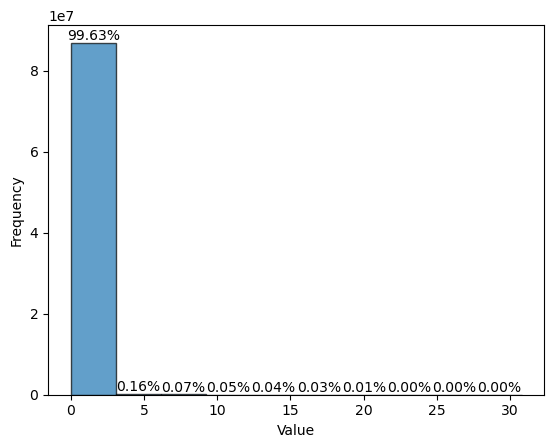

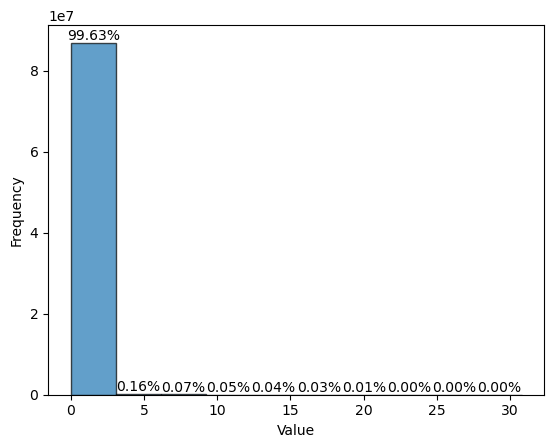

max suv in this: 21.856908207178435


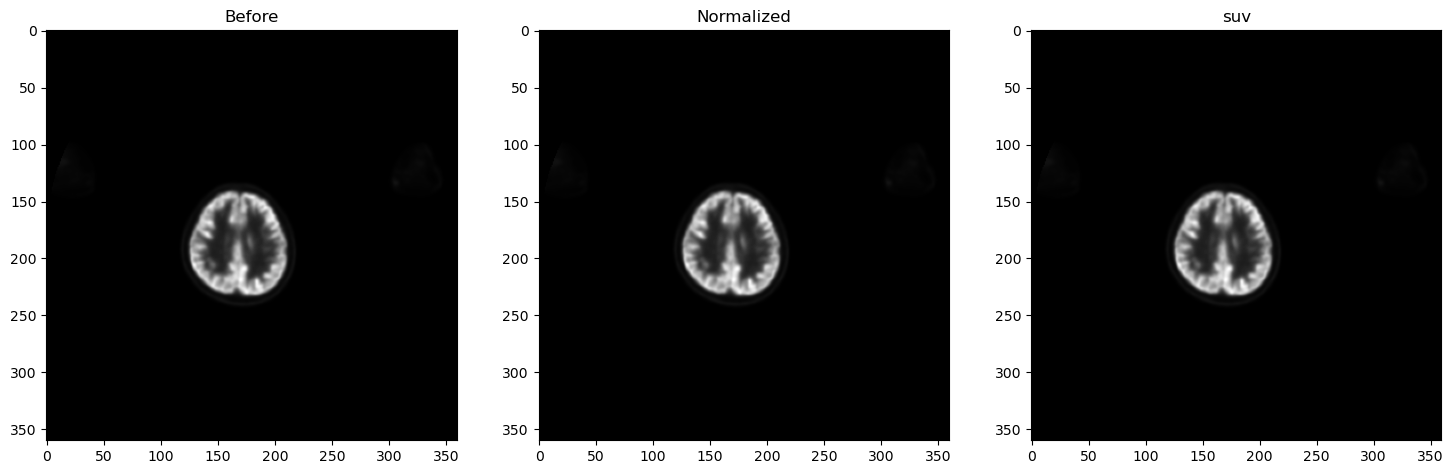

In [6]:
uExplorer_dir = "uExplorer/1st_uExplorer"
directory_name = "Anonymous_ANO_20220224_1826572_121743/2.886 x 600 WB NORMAL"
file_index = 77 # start from 1

dataVolume = loadPETValue(os.path.join(dataset_dir, uExplorer_dir, directory_name))
scaleFactor = calScaleFactor(dataVolume)
print(scaleFactor * 10, scaleFactor)
pixel_array = dataVolume[file_index-1]
windowed_image = (pixel_array) / (scaleFactor * 50)
# windowed_image = MaxMinNormalizer(windowed_image, np.max(dataVolume)/(10*scaleFactor))
print(f"max in windowed: {np.max(windowed_image)}")

# normalized_image = MaxMinNormalizer(pixel_array)
suvVolume = calSUVVolume(os.path.join(dataset_dir, uExplorer_dir, directory_name))
print(f"Mean SUV: {np.mean(suvVolume)}, Max SUV: {np.max(suvVolume)}")
data = normSUV(suvVolume, threshold=None) 
viewData(suvVolume)
viewData(data)
suv_image = data[file_index-1]
print(f"max suv in this: {np.max(suv_image)}")
original_image = pixel_array*255.0

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(original_image, cmap="gray")
plt.title('Before')
plt.subplot(1,3,2)
plt.imshow(windowed_image, cmap="gray")
plt.title('Normalized')
plt.subplot(1,3,3)
plt.imshow(suv_image, cmap="gray")
plt.title('suv')
plt.show()

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0014) Instance Creator UID                UI: ''
(0008, 0016) SOP Class UID                       UI: Positron Emission Tomography Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.1.4.10001.30000021120117001081200007746
(0008, 0020) Study Date                          DA: '20211201'
(0008, 0021) Series Date                         DA: '20211201'
(0008, 0022) Acquisition Date                    DA: '20211201'
(0008, 0023) Content Date                        DA: '20211201'
(0008, 0030) Study Time                          TM: '130644.938000'
(0008, 0031) Series Time                         TM: '131216.000000'
(0008, 0032) Acquisition Time                    TM: '131646.000000'
(0008, 0033) Content Time                        TM: '133525.360000'
(0008, 0050) Accession Number                    SH: ''
(0008, 0

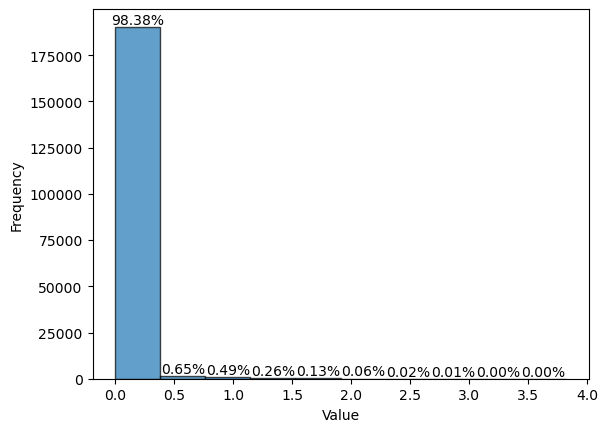

Mean SUV: 0.019765167517239404, Max SUV: 3.819684043143586


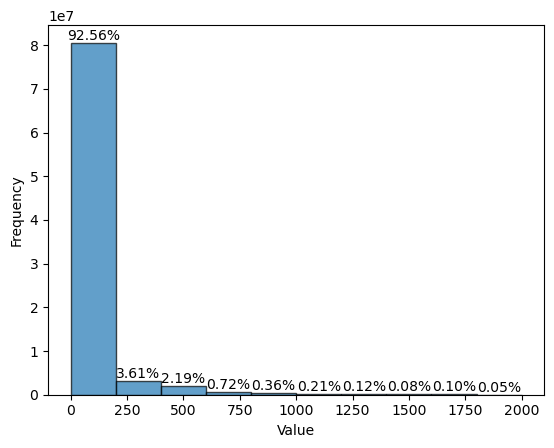

1935.0 397.97796951891667
data max: 7.954209133301116, data min: 0.0
max in windowed: 31.51250947687642
data max: 1956, data min: 0


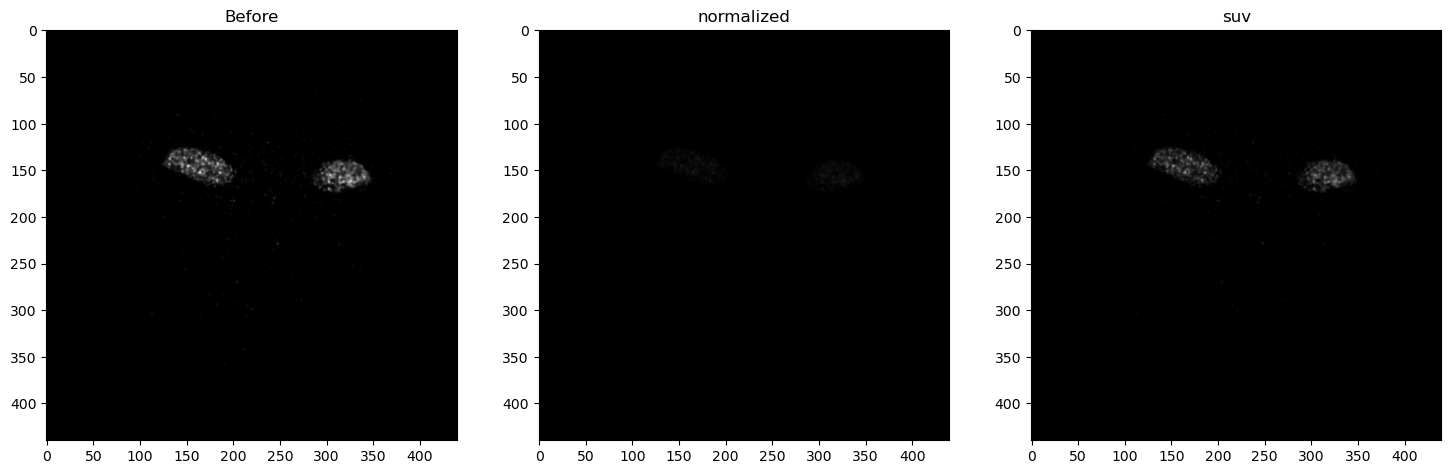

In [7]:
siemens_dir = "BSiemens/Subjects"
file_name = "01122021_1_20211201_164050/1-10 dose/01122021_1.PT.12.5.2021.12.01.17.02.10.426000.4.0.890700635.IMA"
full_file_name = os.path.join(dataset_dir, siemens_dir, file_name)

ds = pydicom.dcmread(full_file_name)
for elem in ds:
    print(elem)
print(ds.pixel_array)
ds.pixel_array.shape

suv = calSUV(ds)
viewData(suv)
print(f"Mean SUV: {np.mean(suv)}, Max SUV: {np.max(suv)}")
suv = normSUV(suv) * 255.0 / 6
pixel_array = ds.pixel_array
# if 'WindowWidth' in ds and 'WindowCenter' in ds:
#     print("WindowWidth and WindowCenter are defined.")
#     window_width = ds.WindowWidth
#     window_center = ds.WindowCenter
#     if isinstance(window_width, pydicom.valuerep.DSfloat):
#         window_width = [window_width]
#     if isinstance(window_center, pydicom.valuerep.DSfloat):
#         window_center = [window_center]
    
#     windowed_image = (pixel_array - (window_center[0] - window_width[0] / 2)) / window_width[0] * 255.0
#     windowed_image = np.clip(windowed_image, 0, 255).astype(np.uint16)
# else:
#     windowed_image = pixel_array
dataVolume = loadPETValue(os.path.join(dataset_dir, uExplorer_dir, "Anonymous_ANO_20220224_1824561_122859/2.886 x 600 WB NORMAL"))
threshold = viewData(dataVolume)
scaleFactor = calScaleFactor(dataVolume)
print(threshold, scaleFactor)
windowed_image = (pixel_array) / (scaleFactor * 5)
windowed_image = MaxMinNormalizer(windowed_image, np.max(dataVolume)/(5*scaleFactor)) * 255
print(f"max in windowed: {np.max(windowed_image)}")

normalized_image = MaxMinNormalizer(pixel_array)
original_image = pixel_array*255.0/ds.WindowWidth

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(original_image, cmap="gray")
plt.title('Before')
plt.subplot(1,3,2)
plt.imshow(windowed_image, cmap="gray", vmin=0, vmax=255)
plt.title('normalized')
plt.subplot(1,3,3)
plt.imshow(suv, cmap="gray", vmin=0, vmax=255)
plt.title('suv')
plt.show()

1356.3090538499855 271.2618107699971
data max: 24.158210775775064, data min: 0.0
max in windowed: 35.48800585973265, max in pixel_array84.05163976189823
Mean SUV: 0.11020335134412593, Max SUV: 79.35343231960704


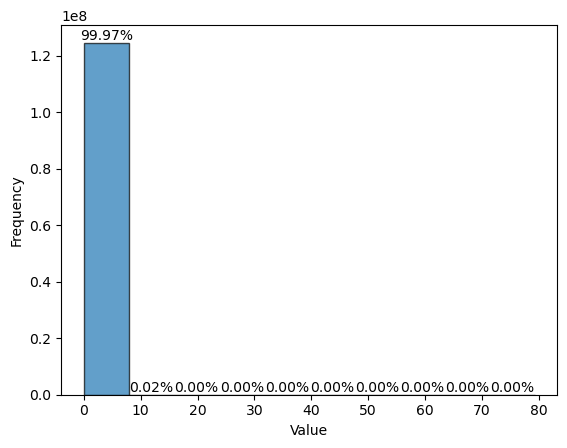

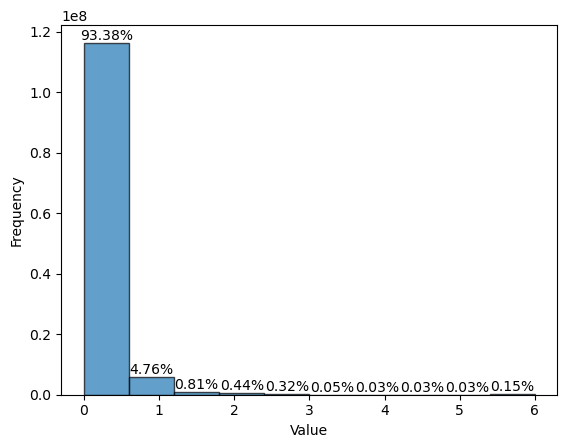

(440, 440)


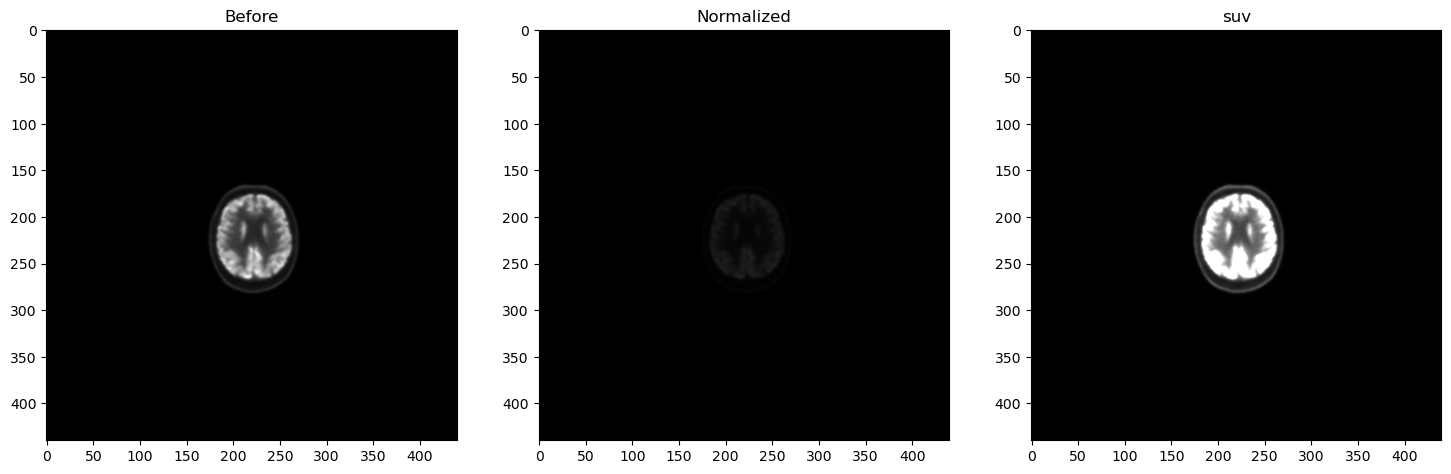

In [8]:
siemens_dir = "BSiemens/testdataset"
directory_name = "04012022_3_20220104_143924/Full_dose"
file_index = 60 # start from 1

dataVolume = loadPETValue(os.path.join(dataset_dir, siemens_dir, directory_name))
scaleFactor = calScaleFactor(dataVolume)
print(scaleFactor * 5, scaleFactor)
pixel_array = dataVolume[file_index-1]
windowed_image = (pixel_array) / (scaleFactor * 5)
windowed_image = MaxMinNormalizer(windowed_image, np.max(dataVolume)/(5*scaleFactor)) * 255
print(f"max in windowed: {np.max(windowed_image)}, max in pixel_array{np.max(pixel_array/scaleFactor * 5)}")

# normalized_image = MaxMinNormalizer(pixel_array)
suvVolume = calSUVVolume(os.path.join(dataset_dir, siemens_dir, directory_name))
print(f"Mean SUV: {np.mean(suvVolume)}, Max SUV: {np.max(suvVolume)}")
data = normSUV(suvVolume, threshold=6) 
viewData(suvVolume)
viewData(data)
data = data * 255.0 / 6
suv_image = data[file_index-1]
print(suv_image.shape)
original_image = pixel_array*255.0/ds.WindowWidth

plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
plt.imshow(original_image, cmap="gray")
plt.title('Before')
plt.subplot(1,3,2)
plt.imshow(windowed_image, cmap="gray", vmin=0, vmax=255)
plt.title('Normalized')
plt.subplot(1,3,3)
plt.imshow(suv_image, cmap="gray", vmin=0, vmax=255)
plt.title('suv')
plt.show()

In [9]:
import matplotlib.image as mpimg
from PIL import Image

def transfer_png_anonymous_dir(directory, dataset,  dose_req = "NORMAL", NORMALIZE = False, SUV = False, suvThreshold = 6.0, output_dir = "pngImage", NPY = False):
    """
    Count the number of files in directories that start with 'Anonymous_' in the given directory.
    :param directory: Path to the directory to search in.
    :param dataset:
    :param dose_req: Dose to transfer to PNG.
    :param NORMALIZE: Normalize the image using scaler or calculate the suv
    :param SUV:
    :param suvThreshold:
    :return: Whether transfer succfully.
    """
    directory_name = directory.split("/")[-1]

    for folder_name in os.listdir(directory):
        if dataset == "uExplorer" and directory_name.startswith('Anonymous_'):
            dose_type = folder_name.split(" ")[-1]
            # print(dose_type)
        elif dataset == "BSiemens":
            dose_type = folder_name.split("dose")[0]
            dose_type = dose_type.split(dose_type[-1])[0]
        else:
            dose_type = None
        if dose_type == dose_req:
            if NORMALIZE:
                data = loadPETValue(os.path.join(directory, folder_name))
                scaleFactor = calScaleFactor(data)
                print(f"Mean: {scaleFactor}, Max:{np.max(data)}")  
                data = data / (scaleFactor * 5)              
                data = MaxMinNormalizer(data, np.max(data)/(5*scaleFactor))

            elif SUV:
                data = calSUVVolume(os.path.join(directory, folder_name))
                print(f"Mean SUV: {np.mean(data[data>0])}, Max SUV: {np.max(data)}")
                data = normSUV(data, threshold=suvThreshold)    
            
            print(f"max {np.max(data)}, shape:{data[0].shape}")                
            for i in range(1,len(data)+1,1):  
                saved_image = data[i-1]                                                         
                saved_folder = os.path.join(dataset_dir, dataset, output_dir, dose_type)
                if not os.path.exists(saved_folder):
                    os.makedirs(saved_folder)
                if NPY:
                    saved_name = dose_type+"_"+ directory_name+"_"+f"{i:03}"+'.npy'               
                    np.save(os.path.join(saved_folder,saved_name), saved_image)
                    # print(os.path.join(saved_folder,saved_name))
                else:
                    # print(i, np.max(saved_image))
                    saved_name = dose_type+"_"+ directory_name+"_"+f"{i:03}"+".png"                 
                    mpimg.imsave(os.path.join(saved_folder,saved_name), saved_image, cmap="gray", vmin=0, vmax=255)       
            return True         
    return False

In [10]:
transfer_number = 14
dose_req = "NORMAL"
NORMALIZE = False
SUV = True
save_npy = True
suvThreshold = None
dataset = "uExplorer"
output_dir = "SUVnpy/"
siemens_dir = "BSiemens/Subjects"
uExplorer_dir = "uExplorer/1st_uExplorer"

dose_list = ["NORMAL", "D2", "D4", "D10", "D20", "D50", "D100", "1-2", "1-4", "1-10", "1-20", "1-50", "1-100", "Full"]
err_results = []
err_cnt = 0
tot_cnt = 0
if dataset == "uExplorer":
    dir = uExplorer_dir
else:
    dir = siemens_dir
for folder_name in sorted(os.listdir(os.path.join(dataset_dir, dir))):
    print('Dose: {}, Transfer {} to png...'.format(dose_req, folder_name))
    folder_path = os.path.join(dataset_dir, dir, folder_name)
    result = transfer_png_anonymous_dir(folder_path, dataset, output_dir = output_dir, dose_req = dose_req, NORMALIZE = NORMALIZE, SUV = SUV, suvThreshold = suvThreshold, NPY = save_npy)
    tot_cnt+=1
    if not result:
        err_results.append(tot_cnt)
        err_cnt+=1
    if tot_cnt >= transfer_number:
        break
print("Successfully transfer {} to png.".format(tot_cnt))
if err_cnt != 0:
    print("Failed to transfer {} to png. Failed number: {}".format(err_cnt, err_results))

Dose: NORMAL, Transfer Anonymous_ANO_20220224_1824561_122859 to png...


Mean SUV: 0.5270014565413947, Max SUV: 25.12417152967481
max 25.12417152967481, shape:(360, 360)
Dose: NORMAL, Transfer Anonymous_ANO_20220224_1826572_121743 to png...
Mean SUV: 0.5442319547822797, Max SUV: 30.7807694832787
max 30.7807694832787, shape:(360, 360)
Dose: NORMAL, Transfer Anonymous_ANO_20220224_1828586_120633 to png...
Mean SUV: 0.5424254010218583, Max SUV: 68.83120579537432
max 68.83120579537432, shape:(360, 360)
Dose: NORMAL, Transfer Anonymous_ANO_20220224_1831028_115350 to png...
Mean SUV: 0.7972436290322769, Max SUV: 383.04349932770424
max 383.04349932770424, shape:(360, 360)
Dose: NORMAL, Transfer Anonymous_ANO_20220224_1833020_114003 to png...
Mean SUV: 0.565503591814776, Max SUV: 17.858653430124882
max 17.858653430124882, shape:(360, 360)
Dose: NORMAL, Transfer Anonymous_ANO_20220224_1835039_111917 to png...
Mean SUV: 0.4574804132462171, Max SUV: 358.08200342368417
max 358.08200342368417, shape:(360, 360)
Dose: NORMAL, Transfer Anonymous_ANO_20220224_1837073_110801